In [1]:
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.spatial import ConvexHull
import random

In [2]:
df = pd.read_csv('dataset.csv')
tics = pd.unique(df.tic)
n = len(df[df.datadate >= 20190514])//3
df = df[df.datadate <= 20190514]

trade_day = 365

prices = pd.DataFrame({})
prices_change = pd.DataFrame({})
variance = pd.Series({},dtype='float64')

for tic in tics:
    prices[tic] = df[df.tic == tic].adjcp[-n:].to_list()
    prices_change[tic] = prices[tic].pct_change().apply(lambda x: np.log(1+x))
    variance[tic] = prices_change[tic].var()
prices['Datetime'] = df[df.tic == tic].datadate[-n:].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')).to_list()
prices = prices.set_index('Datetime')

cov_matrix = prices_change.cov()

expect_return = prices.resample('Y').last().pct_change().mean()
assets = pd.concat([expect_return, variance], axis=1)
assets.columns = ['Returns', 'Variance']
num_assets = len(prices.columns)

assets

Returns  Variance
Bitcoin   0.223585  0.002056
Ethereum -0.080340  0.003511
Monero   -0.016942  0.004651

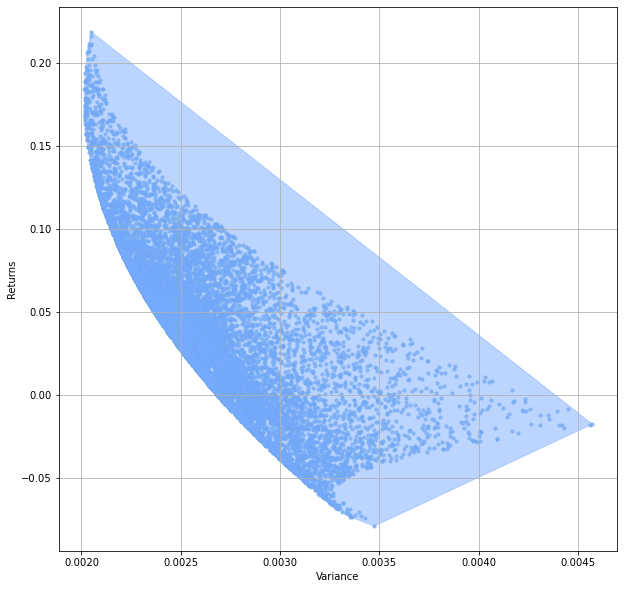

In [3]:

p_ret = []
p_var = []
p_weights = []

num_sample = 10000

for i in range(num_sample):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, expect_return)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum() # Portfolio Variance
    p_var.append(var)

data = {'Returns':p_ret, 'Variance':p_var}
for counter, symbol in enumerate(prices.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

portfolios_sample  = pd.DataFrame(data)
ax = portfolios_sample.plot.scatter(x='Variance', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10])

samples = np.vstack((portfolios_sample['Variance'].to_numpy(),portfolios_sample['Returns'].to_numpy())).T
hull = ConvexHull(samples)
plt.fill(samples[hull.vertices,0], samples[hull.vertices,1],color="#78acff",alpha=0.5)
plt.scatter(portfolios_sample['Variance'], portfolios_sample['Returns'],marker='o',color="#78acff",s=10, alpha=0.3)
plt.savefig('region.png')


In [4]:

def get_return(weights):
    return np.dot(weights, expect_return)

def get_variance(weights):
    return cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()

def get_variance_diff(weights):
    diff = np.zeros(len(weights))
    for index in range(len(weights)):
        for tic_i, tic in enumerate(tics):
            diff[index] += 2 * cov_matrix[tic][tics[index]] * weights[tic_i]
    return diff

Returns = []
Variances = []

def gradient_descent(weights = np.zeros(num_assets) + 1/num_assets):
    learn_rate = 0.1

    # weights = np.zeros(num_assets) + 1/num_assets

    min_weight = np.copy(weights)
    min_variance = get_variance(weights)

    for i in range(50000):

        diff = get_variance_diff(weights)
        weights -= diff * learn_rate
        weights = np.clip(weights, 0, 1)
        weights = weights / sum(weights)
        variance = get_variance(weights)
        returns = get_return(weights)

        if variance > min_variance:
            if learn_rate < 1e-20:
                break
            learn_rate *= 0.99
            weights = np.copy(min_weight)
        else:
            min_variance = variance
            min_weight = np.copy(weights)
            Returns.append(returns)
            Variances.append(variance)

        print(f'\r{i} weights:{weights} New variance: {variance} learn_rate: {learn_rate}',end="")
        # print(f'{i} weights:{weights} New variance: {variance} learn_rate: {learn_rate}',end="\n")


    print("\ndone")
    print("weight: ",min_weight)
    print("variance: ",min_variance)
    print("\n\n")
    return min_weight, min_variance

min_weight, min_variance = gradient_descent()
for k in range(3):
    w = np.zeros(num_assets)
    for i in range(num_assets):
        w[i] = random.uniform(0, 1)
    w = w / np.sum(w)
    gradient_descent(w)

data = {'Returns':Returns, 'Variance':Variances}
portfolios  = pd.DataFrame(data)




6175 weights:[0.85470258 0.14529742 0.        ] New variance: 0.002012559294621306 learn_rate: 9.900047486404971e-21
done
weight:  [0.85470258 0.14529742 0.        ]
variance:  0.002012559294621305



4598 weights:[0.3456371  0.58916781 0.06519509] New variance: 0.0024928714888260476 learn_rate: 9.900047486404971e-21
done
weight:  [0.3456371  0.58916781 0.06519509]
variance:  0.0024928714888260463



5659 weights:[0.88004673 0.11995327 0.        ] New variance: 0.0020138772920127363 learn_rate: 9.900047486404971e-21
done
weight:  [0.88004673 0.11995327 0.        ]
variance:  0.0020138772920127355



4358 weights:[0.2214939  0.39283951 0.3856666 ] New variance: 0.0027818170594023648 learn_rate: 9.900047486404971e-21
done
weight:  [0.2214939  0.39283951 0.3856666 ]
variance:  0.002781817059402363





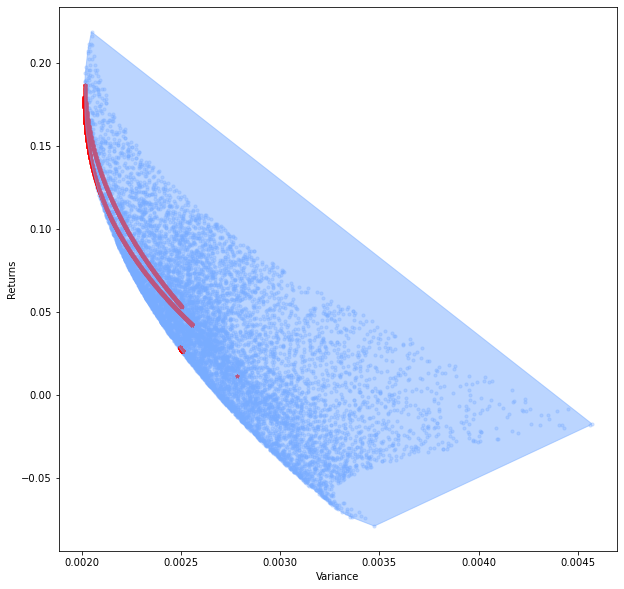

In [5]:
plt.subplots(figsize=[10,10])

samples = np.vstack((portfolios_sample['Variance'].to_numpy(),portfolios_sample['Returns'].to_numpy())).T
hull = ConvexHull(samples)
plt.fill(samples[hull.vertices,0], samples[hull.vertices,1],color="#78acff",alpha=0.5)
plt.scatter(portfolios_sample['Variance'], portfolios_sample['Returns'],marker='o',color="#78acff",s=10, alpha=0.3)
plt.scatter(portfolios['Variance'], portfolios['Returns'], color='r', marker='*', s=10)
plt.xlabel('Variance')
plt.ylabel('Returns')
plt.savefig('region_gradient.png')
plt.show()

Minimum Variance Weight:

Bitcoin :	 0.8547025752265799
Ethereum :	 0.14529742477342
Monero :	 0.0


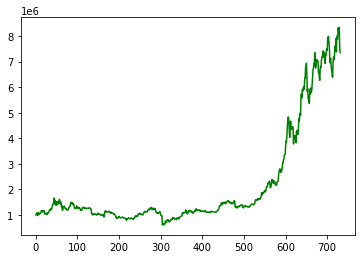

In [6]:
# number of trade date
n = n

df = pd.read_csv('dataset.csv')
tics = pd.unique(df.tic)

print("Minimum Variance Weight:\n")
weights = {}
for idx, tic in enumerate(tics):
    print(tic,":\t", min_weight[idx])
    weights[tic] = min_weight[idx]

account_value = np.zeros(n)
for tic in tics:
    price = df[df.tic == tic].open[-n:].to_numpy()
    price *= (1000000 * weights[tic]) / price[0]
    account_value += price

pd.DataFrame(account_value).to_csv("./results/account_value_min_var.csv")

plt.plot( account_value, 'g')
plt.show()
